# PSP Heliophysics Scholars Meeting
### Oct 18 2023

This is a notebook draft for the meeting. The plan is :

* How to get data with sunpy-soar
* How to download data (e.g. se Mar 25 2022)
* Workflow analysis of Sept 5 2022 event

In [1]:
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import pandas as pd
from sunpy.net import Fido, attrs as a 
from sunpy.coordinates import frames, get_horizons_coord
from sunpy.time import parse_time
import sunpy.map
import sunpy.timeseries
import sunpy_soar
from astropy import units as u 
from astropy.coordinates import SkyCoord
from astropy.visualization import PowerStretch, AsinhStretch
from astropy.wcs import WCS
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import constants as const
from reproject.mosaicking import reproject_and_coadd
from reproject import reproject_interp
import stixpy
from stixpy.net.client import STIXClient 
import stixpy.timeseries

In [2]:
%matplotlib widget

# 1. How to access and download Solar Orbiter data

## Overview of Fido Unified Downloader
Fido is sunpy's interface for searching and downloading solar physics data.
It offers a unified interface for searching and fetching data irrespective of the underlying client or webservice from where the data is obtained.
You can also search and accesses multiple instruments and all available data providers in a single query.
It supplies a single, easy, consistent and extendable way to get most forms of solar physics data the community need.

For more information about Fido and how to use it check out the documentation on our website: https://docs.sunpy.org/en/stable/tutorial/acquiring_data/index.html

Fido offers access to data available through:

* VSO
* JSOC (through drms)
* Individual data providers from web accessible sources (http, ftp, etc)
* HEK
* HELIO
  
As described here Fido provides access to many sources of data through different clients, these clients can be defined inside sunpy or in other packages (e.g. DKIST data can be accessed using Fido through [DKIST User Tools](https://docs.dkist.nso.edu/projects/python-tools/en/latest/tutorial/2_search_and_asdf_download.html).

#### Importantly, Solar Orbiter data can be accessed through the client defined in the `sunpy_soar` affiliated package. 

Lets inspect what instrument and clients are available through Fido. 

In [3]:
a.Provider

<class 'sunpy.net.attrs.Provider'>
sunpy.net.attrs.Provider

Specifies the data provider to search for data using Fido.

Attribute Name ...
-------------- ...
esa            ...
esa            ...
hao            ...
hsos           ...
inaf_oact      ...
jsoc           ...
kso            ...
lasp           ...
lasp           ...
lmsal          ...
lssp           ...
mps            ...
msfc           ...
msu            ...
mwspadp        ...
naoj           ...
nasa           ...
nasa           ...
noaa           ...
noaa           ...
noaa           ...
noaa           ...
nrl            ...
nro            ...
nso            ...
nso            ...
nwra           ...
obspm          ...
rob            ...
sdac           ...
sdac           ...
sha            ...
soar           ...
ssc            ...
swpc           ...
swpc           ...

There are also Solar Orbiter specific attributes, suych as Product, and SOOP (Solar Orbiter Observing Plan)

In [4]:
a.soar.Product

<class 'sunpy_soar.attrs.Product'>
sunpy_soar.attrs.Product

The data product identifier to search for.

         Attribute Name         ...
------------------------------- ...
epd_ept_asun_burst_ele_close    ...
epd_ept_asun_burst_ion          ...
epd_ept_asun_hcad               ...
epd_ept_asun_rates              ...
epd_ept_north_burst_ele_close   ...
epd_ept_north_burst_ion         ...
epd_ept_north_hcad              ...
epd_ept_north_rates             ...
epd_ept_south_burst_ele_close   ...
epd_ept_south_burst_ion         ...
epd_ept_south_hcad              ...
epd_ept_south_rates             ...
epd_ept_sun_burst_ele_close     ...
epd_ept_sun_burst_ion           ...
epd_ept_sun_hcad                ...
epd_ept_sun_rates               ...
epd_epthet1_burst1_close        ...
epd_epthet1_burst2_close        ...
epd_epthet1_burst3_close        ...
epd_epthet1_nom_close           ...
epd_epthet1_nom_far             ...
epd_epthet1_quicklook           ...
epd_epthet1_sc                  ...
epd_epthet2_burst1_close        ...
epd_epthet2_burst2_close        ...
epd_epthet2_burst3_close        ...
epd_epthet2_nom_close           ...
epd_epthet2_nom_far             ...
epd_epthet2_quicklook           ...
epd_epthet2_sc                  ...
epd_het_asun_burst              ...
epd_het_asun_rates              ...
epd_het_north_burst             ...
epd_het_north_rates             ...
epd_het_south_burst             ...
epd_het_south_rates             ...
epd_het_sun_burst               ...
epd_het_sun_rates               ...
epd_sis_a_hehist                ...
epd_sis_a_rates                 ...
epd_sis_a_rates_fast            ...
epd_sis_a_rates_medium          ...
epd_sis_a_rates_slow            ...
epd_sis_b_hehist                ...
epd_sis_b_rates                 ...
epd_sis_b_rates_fast            ...
epd_sis_b_rates_medium          ...
epd_sis_b_rates_slow            ...
epd_step_aux                    ...
epd_step_burst                  ...
epd_step_burst1_close           ...
epd_step_hcad                   ...
epd_step_main                   ...
epd_step_main_close             ...
epd_step_main_far               ...
epd_step_nom_close              ...
epd_step_nom_far                ...
epd_step_quicklook              ...
epd_step_rates                  ...
eui_fsi174_image                ...
eui_fsi174_image_dark           ...
eui_fsi174_image_occulter       ...
eui_fsi174_image_short          ...
eui_fsi304_image                ...
eui_fsi304_image_dark           ...
eui_fsi304_image_led            ...
eui_fsi304_image_occulter       ...
eui_fsi304_image_short          ...
eui_fsiblk_image                ...
eui_fsiblk_image_dark           ...
eui_fsiblk_image_led            ...
eui_hrieuv174_image             ...
eui_hrieuv174_image_dark        ...
eui_hrieuv174_image_led         ...
eui_hrieuv174_image_short       ...
eui_hrieuv____image             ...
eui_hrieuvblk_image             ...
eui_hrieuvblk_image_dark        ...
eui_hrieuvblk_image_led         ...
eui_hrieuvnon_image             ...
eui_hrieuvopn_image             ...
eui_hrieuvopn_image_dark        ...
eui_hrieuvopn_image_led         ...
eui_hrieuvzer_image             ...
eui_hrieuvzer_image_dark        ...
eui_hrieuvzer_image_led         ...
eui_hrieuvzer_image_short       ...
eui_hrilya1216_image            ...
eui_hrilya1216_image_dark       ...
eui_hrilya1216_image_led        ...
mag                             ...
mag_ibs                         ...
mag_obs                         ...
mag_rtn                         ...
mag_rtn_burst                   ...
mag_rtn_normal                  ...
mag_rtnderivedfromlldata        ...
mag_srf                         ...
mag_srf_burst                   ...
mag_srf_normal                  ...
mag_srfderivedfromlldata        ...
mag_vso                         ...
mag_vso_burst                   ...
mag_vso_normal                  ...
metis_uv_image                  ...
metis_vl_image                  ...
metis_v

In [5]:
a.soar.SOOP

<class 'sunpy_soar.attrs.SOOP'>
sunpy_soar.attrs.SOOP

The SOOP name to search for.


                 Attribute Name                  Client ... Description
------------------------------------------------ ------ ... -----------
cc_offpoi_alignment                              SOAR   ...            
cc_offpoi_flatfield_full                         SOAR   ...            
cc_offpoi_flatfield_hri                          SOAR   ...            
cc_offpoi_oof                                    SOAR   ...            
cc_offpoi_star                                   SOAR   ...            
cc_offpoi_straylight                             SOAR   ...            
cc_rolls_rs                                      SOAR   ...            
coord_calibration                                SOAR   ...            
i_default                                        SOAR   ...            
l_both_hres_hcad_major_flare                     SOAR   ...            
l_both_hres_lcad_ch_boundary_expansion           SOAR   ...            
l_both_lres_mcad_pole_to_pole                    SOAR   ...            
l_both_mres_mcad_farside_connection              SOAR   ...            
l_both_mres_mcad_flare_seps                      SOAR   ...            
l_full_hres_hcad_coronal_dynamics                SOAR   ...            
l_full_hres_hcad_eruption_watch                  SOAR   ...            
l_full_hres_lcad_magnfieldconfig                 SOAR   ...            
l_full_hres_mcad_coronal_he_abundance            SOAR   ...            
l_full_lres_mcad_coronal_synoptic                SOAR   ...            
l_full_lres_mcad_probe_quadrature                SOAR   ...            
l_full_mres_mcad_cme_seps                        SOAR   ...            
l_is_solohi_stix                                 SOAR   ...            
l_is_stix                                        SOAR   ...            
l_small_hres_hcad_fast_wind                      SOAR   ...            
l_small_hres_hcad_slow_wind_connection           SOAR   ...            
l_small_mres_mcad_ballistic_connection           SOAR   ...            
l_small_mres_mcad_composition_mosaic             SOAR   ...            
l_small_mres_mcad_connection_mosaic              SOAR   ...            
l_small_mres_mcad_earth_quadrature               SOAR   ...            
l_temporary                                      SOAR   ...            
r_both_hres_hcad_filaments                       SOAR   ...            
r_both_hres_hcad_nanoflares                      SOAR   ...            
r_both_hres_mcad_bright_points                   SOAR   ...            
r_full_hres_hcad_density_fluctuations            SOAR   ...            
r_full_lres_hcad_full_disk_helioseismology       SOAR   ...            
r_full_lres_lcad_out_of_rsw_synoptics            SOAR   ...            
r_full_lres_lcad_transition_corona               SOAR   ...            
r_small_hres_hcad_ar_dynamics                    SOAR   ...            
r_small_hres_hcad_atmospheric_dynamics_structure SOAR   ...            
r_small_hres_hcad_ephemeral                      SOAR   ...            
r_small_hres_hcad_granulation_tracking           SOAR   ...            
r_small_hres_hcad_local_area_helioseismology     SOAR   ...            
r_small_hres_hcad_pdf_mosaic                     SOAR   ...            
r_small_hres_hcad_rs_burst                       SOAR   ...            
r_small_hres_hcad_wave_stereoscopy               SOAR   ...            
r_small_hres_lcad_composition_vs_height          SOAR   ...            
r_small_hres_lcad_fine_scale_structure           SOAR   ...            
r_small_hres_mcad_ar_heating                     SOAR   ...            
r_small_hres_mcad_full_disk_mosaic               SOAR   ...            
r_small_hres_mcad_polar_observations             SOAR   ...            
r_small_mres_hcad_sunspot_oscillations           SOAR   ...            
r_small_mres_mcad_ar_long_term                   SOAR   ...

## Lets construct a query

Let's search for EUI data over a timerange

In [6]:
res_eui = Fido.search(a.Time("2022-03-25", "2022-03-26"), 
                  a.Instrument("EUI"), 
                  a.Provider.soar)

We can also construct a query to search for SWA data (in-situ), note that there's no SOOP name associated.

In [7]:
res_swa = Fido.search(a.Time("2022-03-25", "2022-03-26"), 
                  a.Instrument("SWA"), 
                  a.Level(2), a.Provider.soar)

Lets search for all data from a particular SOOP

In [8]:
res_soop = Fido.search(a.Time("2022-03-25", "2022-03-25 01:00"), 
                  a.soar.SOOP.l_full_hres_hcad_coronal_dynamics, 
                  a.Provider.soar)

We can also search for all data available from the SOAR between two times

In [9]:
res_all_solo_timerange = Fido.search(a.Time("2022-03-25", "2022-03-25 01:00"), 
                                     a.Provider.soar)

In [10]:
res_eui_soop = Fido.search(a.Time("2022-03-25", "2022-03-25 01:00"), 
                           a.soar.SOOP.l_full_hres_hcad_coronal_dynamics, 
                           a.Level(2), a.Provider.soar, a.Instrument("EUI"))

### Then to download the files, you can use `Fido.fetch`

So far we have only queried data and inspected what data is available, we havent actually downloaded anything yet. 
Lets download some EUI data

In [11]:
files = Fido.fetch(res_eui_soop, path="./")

Files Downloaded:   0%|          | 0/12 [00:00<?, ?file/s]

In [12]:
files[0]

'solo_L2_eui-fsi304-image_20220325T000815304_V02.fits'

### You can then read this data into a sunpy.map.Map

In [13]:
eui_map = sunpy.map.Map(files[0])

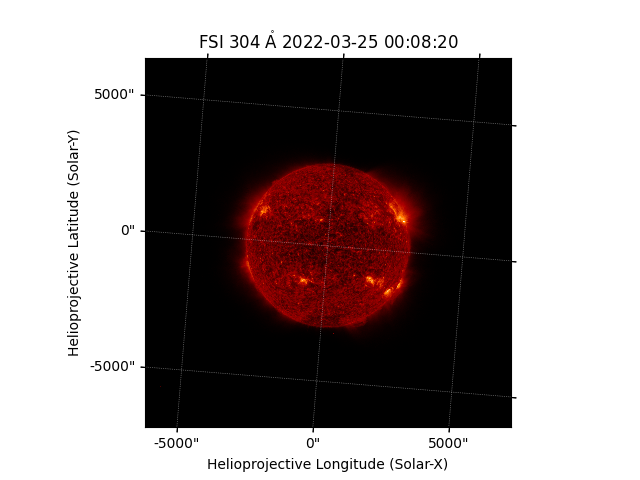

In [14]:
fig = plt.figure()
eui_map.plot()

In [15]:
res_mag = Fido.search(a.Time("2022-03-25", "2022-03-25 23:00"),
                      a.Instrument.mag, 
                      a.soar.Product('mag-rtn-normal-1-minute'), 
                      a.Level(2))

In [16]:
mag_files = Fido.fetch(res_mag, path="./")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [17]:
mag_data = sunpy.timeseries.TimeSeries(mag_files)

<Axes: xlabel='EPOCH', ylabel='nT'>

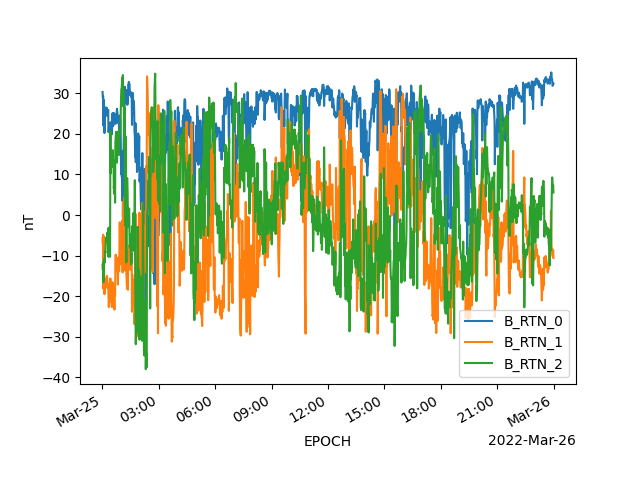

In [18]:
fig = plt.figure()
mag_data.plot(columns=["B_RTN_0", "B_RTN_1", "B_RTN_2"])

# Accessing data from the CDAWeb with sunpy - which is very helpful for in-situ data

There is also a CDAWeb client within sunpy. CDAWeb data can be accessed when the `cdaweb.Dataset` attribute is provided to the search.

The data available from the SOAR is also available from the CDAWeb. You may be used to working with this, so lets go through how the data can also be accessed this way

In [19]:
a.cdaweb.Dataset

<class 'sunpy.net.cdaweb.attrs.Dataset'>
sunpy.net.cdaweb.attrs.Dataset

Dataset ID.


                    Attribute Name                    ...
----------------------------------------------------- ...
a1_k0_mpa                                             ...
a2_k0_mpa                                             ...
ac_at_def                                             ...
ac_h0_mfi                                             ...
ac_h0_swe                                             ...
ac_h1_epm                                             ...
ac_h1_mfi                                             ...
ac_h1_sis                                             ...
ac_h2_cris                                            ...
ac_h2_epm                                             ...
ac_h2_mfi                                             ...
ac_h2_sep                                             ...
ac_h2_sis                                             ...
ac_h2_swe                                             ...
ac_h2_swi                                             ...
ac_h2_ule                                             ...
ac_h3_cris                                            ...
ac_h3_epm                                             ...
ac_h3_mfi                                             ...
ac_h3_sw2                                             ...
ac_h3_swi                                             ...
ac_h4_swi                                             ...
ac_h5_swi                                             ...
ac_h6_swi                                             ...
ac_k0_epm                                             ...
ac_k0_gifwalk                                         ...
ac_k0_mfi                                             ...
ac_k0_sis                                             ...
ac_k0_swe                                             ...
ac_k1_epm                                             ...
ac_k1_mfi                                             ...
ac_k1_swe                                             ...
ac_k2_mfi                                             ...
ac_or_def                                             ...
ac_or_ssc                                             ...
aerocube_6_a_dosimeter_l2                             ...
aerocube_6_b_dosimeter_l2                             ...
aim_cips_sci_3a                                       ...
alouette2_av_lim                                      ...
alouette2_av_qui                                      ...
alouette2_av_snt                                      ...
alouette2_av_sol                                      ...
alouette2_av_ula                                      ...
alouette2_av_wnk                                      ...
alouette2_neprof_tops                                 ...
amptecce_h0_mepa                                      ...
apollo12_sws_1hr                                      ...
apollo12_sws_28s                                      ...
apollo15_sws_1hr                                      ...
apollo15_sws_28s                                      ...
bar_1a_l2_ephm                                        ...
bar_1a_l2_fspc                                        ...
bar_1a_l2_hkpg                                        ...
bar_1a_l2_magn                                        ...
bar_1a_l2_mspc                                        ...
bar_1a_l2_rcnt                                        ...
bar_1a_l2_sspc                                        ...
bar_1b_l2_ephm                                        ...
bar_1b_l2_fspc                                        ...
bar_1b_l2_hkpg                                        ...
bar_1b_l2_magn                                        ...
bar_1b_l2_mspc                                        ...
bar_1b_l2_rcnt                                        ...
bar_1b_l2_sspc                                        ...
bar_1c_l2_ephm                                        ...
bar_1c_l2_fspc             

In [20]:
res_cdaw = Fido.search(a.Time("2022-03-25", "2022-03-26"), 
                       a.cdaweb.Dataset('SOLO_L2_MAG-RTN-NORMAL-1-MINUTE'))

In [21]:
res_cdaw

<sunpy.net.fido_factory.UnifiedResponse object at 0x12cb5b490>
Results from 1 Provider:

1 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

            Dataset                    Start time               End time       
------------------------------- ----------------------- -----------------------
SOLO_L2_MAG-RTN-NORMAL-1-MINUTE 2022-03-25 00:00:29.000 2022-03-25 23:59:30.000

In [22]:
solo_mag_file = Fido.fetch(res_cdaw, path="./")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [23]:
solo_mag_ts = sunpy.timeseries.TimeSeries(solo_mag_file)

<Axes: xlabel='EPOCH', ylabel='nT'>

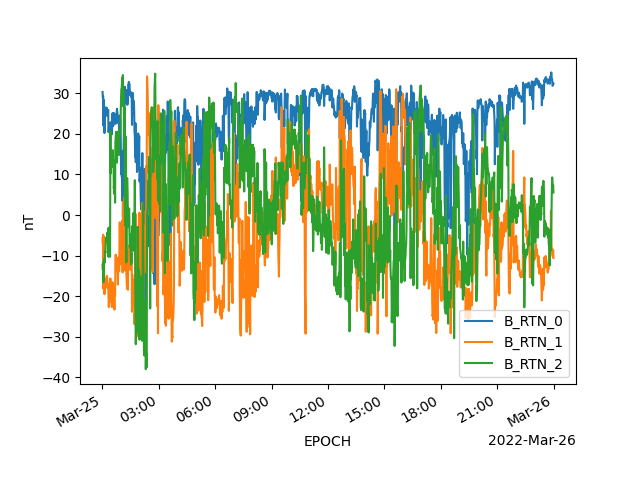

In [24]:
fig = plt.figure()
solo_mag_ts.plot(columns=["B_RTN_0", "B_RTN_1", "B_RTN_2"])

# 2. Scientific Workflow within the SunPy Ecosystem

Lets do an event study with Solar Orbiter and PSP observations. We'll choose a lage eruptive event that occured last September on the backside of the disk as seen from Earth.

In [25]:
tstart = parse_time("2022-09-05 14:30")
tend = parse_time("2022-09-05 23:59")

#### Lets first get the positions  of the spacecraft 

In [26]:
solo_coord = get_horizons_coord("solo", tstart)
psp_coord =  get_horizons_coord("psp", tstart)
earth_coord =  get_horizons_coord("399", tstart)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Earth (399) [sunpy.coordinates.ephemeris]


INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


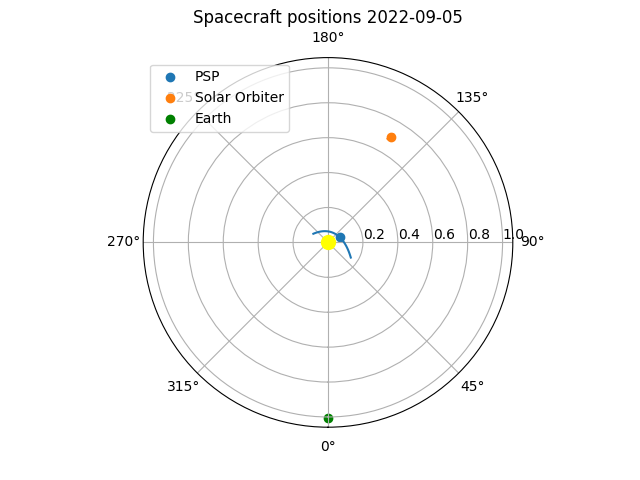

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection="polar")

ax.scatter(psp_coord.lon.to('rad'), psp_coord.radius.to(u.AU),
           label='PSP', lw=1)
ax.scatter(solo_coord.lon.to('rad'), solo_coord.radius.to(u.AU),
           label='Solar Orbiter', lw=1)
ax.scatter(earth_coord.lon.to('rad'), earth_coord.radius.to(u.AU),
           label='Earth', color='g')
ax.plot(0, 0, marker='o', ms=10, color='yellow')

psp_seq = get_horizons_coord("psp", tstart+np.arange(-2, 2, 0.1)*u.day)
solo_seq = get_horizons_coord("solo", tstart + np.arange(-2, 2, 0.1)*u.day)
for coord in [psp_seq, solo_seq]:
    ax.plot(coord.lon.to('rad'), coord.radius.to(u.AU))

ax.set_theta_zero_location("S")
ax.set_rlabel_position(90)
ax.set_title("Spacecraft positions {:s}".format(tstart.strftime("%Y-%m-%d")))
ax.legend(loc="upper left")

In [28]:
stix_ql_query = Fido.search(a.Time(tstart, tend), a.Instrument.stix,
                            a.stix.DataProduct.ql_lightcurve)

In [29]:
Fido.fetch(stix_ql_query, path="./")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['solo_L1_stix-ql-lightcurve_20220905_V01.fits']

In [30]:
stix_ts = sunpy.timeseries.TimeSeries("solo_L1_stix-ql-lightcurve_20220905_V01.fits").truncate(tstart.datetime, tend.datetime)

[[<matplotlib.lines.Line2D at 0x12ceb5c90>],

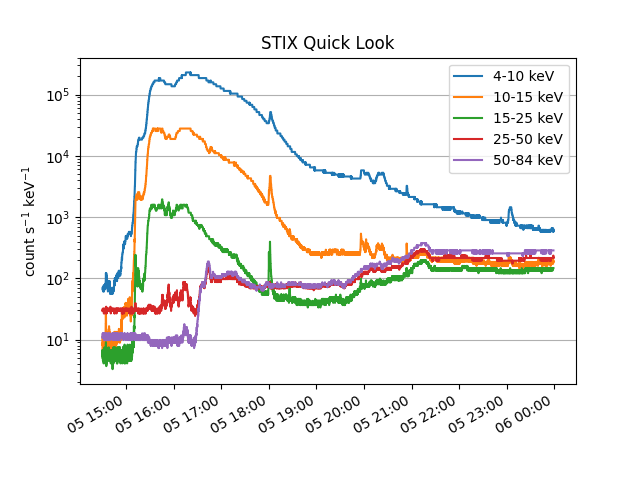

In [31]:
stix_ts.plot()

In [32]:
flare_time = stix_ts.time[np.argmax(stix_ts.quantity("4-10 keV"))]

In [33]:
flare_time

<Time object: scale='utc' format='iso' value=2022-09-05 16:15:58.801>

In [34]:
eui_query = Fido.search(a.Time(tstart, tend), 
                        a.soar.Product("eui-fsi304-image") |  a.soar.Product("eui-fsi174-image") , 
                        a.Level(2))

In [35]:
phi_query = Fido.search(a.Time(tstart, tend), 
                        a.Instrument.phi, a.soar.Product('phi-fdt-blos'),
                        a.Level(2))

In [36]:
phi_query

<sunpy.net.fido_factory.UnifiedResponse object at 0x12cf24dd0>
Results from 1 Provider:

3 Results from the SOARClient:

Instrument Data product Level        Start time               End time        Filesize SOOP Name
                                                                               Mbyte            
---------- ------------ ----- ----------------------- ----------------------- -------- ---------
       PHI phi-fdt-blos    L2 2022-09-05 16:00:09.868 2022-09-05 16:01:10.904     3.43      None
       PHI phi-fdt-blos    L2 2022-09-05 19:00:09.777 2022-09-05 19:01:10.933     3.43      None
       PHI phi-fdt-blos    L2 2022-09-05 22:00:09.713 2022-09-05 22:01:10.743     3.43      None

In [37]:
eui_files = Fido.fetch(eui_query, path="./{instrument}/{file}")

Files Downloaded:   0%|          | 0/95 [00:00<?, ?file/s]

In [38]:
phi_files = Fido.fetch(phi_query, path="./{instrument}/{file}")

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

In [39]:
phi_maps = sunpy.map.Map("./PHI/*.fits")

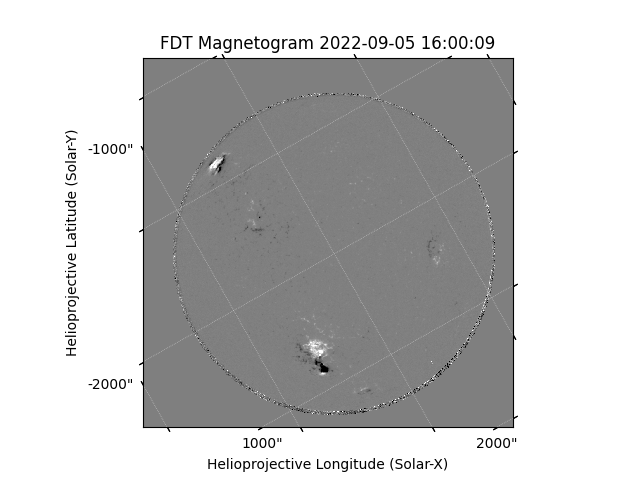

In [40]:
fig = plt.figure()
phi_maps[0].plot(vmin=-500, vmax=500)

In [41]:
phi_maps = [m.rotate(missing=0) for m in phi_maps]

(<matplotlib.patches.Circle at 0x12d2a8e10>, None)

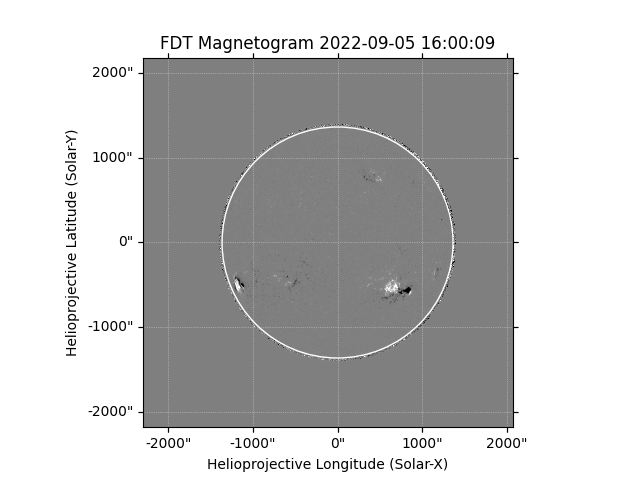

In [42]:
fig = plt.figure()
phi_maps[0].plot(vmin=-500, vmax=500)
phi_maps[0].draw_limb()

In [43]:
eui_maps_304 = sunpy.map.Map("./EUI/*fsi304*")

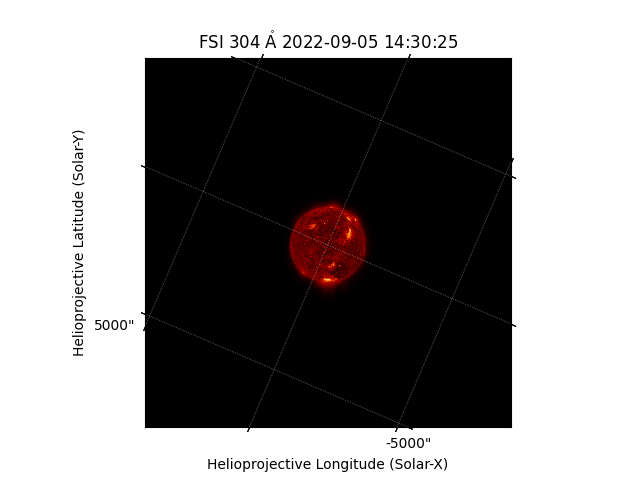

In [44]:
fig = plt.figure()
eui_maps_304[0].plot()

In [45]:
def make_subs(m):
    bl = SkyCoord(-2000*u.arcsec, -2000*u.arcsec, frame=m.coordinate_frame)
    tr = SkyCoord(2000*u.arcsec, 2000*u.arcsec, frame=m.coordinate_frame)
    return m.submap(bl, top_right=tr).rotate(missing=0)

In [46]:
eui_subs_304 = sunpy.map.Map([make_subs(m) for m in eui_maps_304], sequence=True)

In [47]:
# fig = plt.figure()
# ani = eui_subs_304.plot()
# ani.save("eui_movie.mp4")

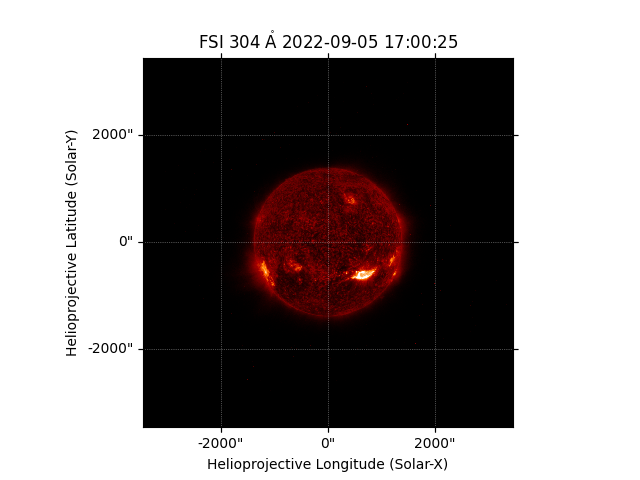

In [48]:
fig = plt.figure()
eui_subs_304[10].plot()

Lets draw a rectangle around the flaring region of interest. 

This can be done using [`sunpy.map.GenericMap.draw_quadrangle`](https://docs.sunpy.org/en/stable/generated/api/sunpy.map.GenericMap.html#sunpy.map.GenericMap.draw_quadrangle)

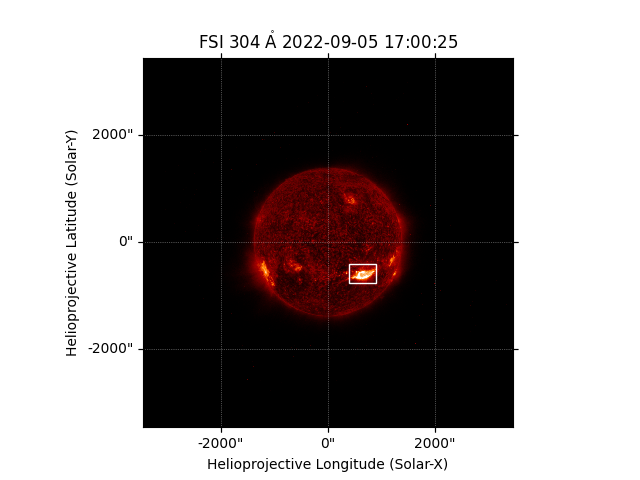

In [49]:
fig = plt.figure()
ax = fig.add_subplot(projection=eui_subs_304[10])
eui_subs_304[10].plot()
# we can also draw a rectangle on the flaring area
eui_subs_304[10].draw_quadrangle(SkyCoord(400*u.arcsec, -750*u.arcsec, frame=eui_subs_304[10].coordinate_frame),
                                 top_right=SkyCoord(900*u.arcsec, -400*u.arcsec, frame=eui_subs_304[10].coordinate_frame))


# Lets see what this looks like from PSP point of view

We can use the coordinates framework with sunpy to reproject images from one viewpoint to another.
To learn more about this, check out our documentation, and also [this](https://docs.sunpy.org/en/stable/generated/gallery/map_transformations/reprojection_different_observers.html#sphx-glr-generated-gallery-map-transformations-reprojection-different-observers-py) example in the example gallery.

In [50]:
ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                     frame='helioprojective', 
                     obstime=eui_subs_304[0].date, 
                     observer=get_horizons_coord("psp", eui_subs_304[0].date))

# Create a FITS WCS header for the reference coordinate and frame
header = sunpy.map.make_fitswcs_header((3000, 3000),
                                        ref_coord,
                                        scale=[16, 16]*u.arcsec/u.pix,
                                      )



INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]


In [51]:
eui_subs_psp = eui_subs_304[0].reproject_to(header)

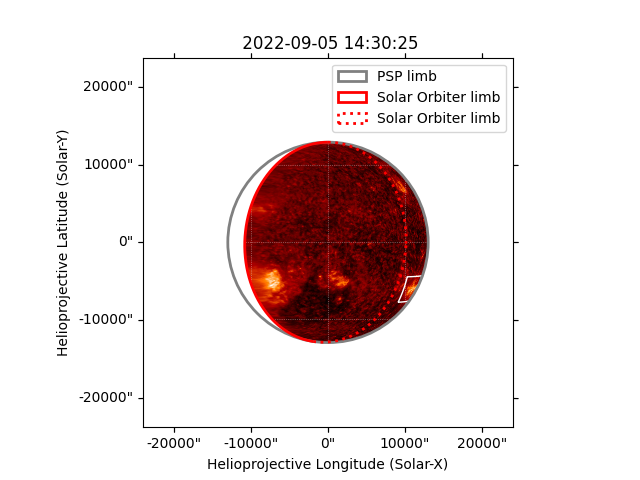

In [52]:
fig = plt.figure()
eui_subs_psp.plot()
eui_subs_psp.draw_limb(color='grey', lw=2, label="PSP limb")
eui_subs_304[0].draw_limb(color='red', lw=2, label="Solar Orbiter limb")
plt.legend()
eui_subs_304[10].draw_quadrangle(SkyCoord(400*u.arcsec, -750*u.arcsec, frame=eui_subs_304[10].coordinate_frame),
                                 top_right=SkyCoord(900*u.arcsec, -400*u.arcsec, frame=eui_subs_304[10].coordinate_frame))

## Lets look for some in-situ data

In [53]:
tstart_insitu = "2022-09-04"
tend_insitu = "2022-09-08"

In [54]:
res_solo_mag = Fido.search(a.Time(tstart_insitu, tend_insitu), 
                           a.cdaweb.Dataset('SOLO_L2_MAG-RTN-NORMAL-1-MINUTE'))
f_solomag = Fido.fetch(res_solo_mag, path="./")
solo_mag = sunpy.timeseries.TimeSeries(f_solomag, concatenate=True)

Files Downloaded:   0%|          | 0/4 [00:00<?, ?file/s]

<Axes: xlabel='EPOCH', ylabel='nT'>

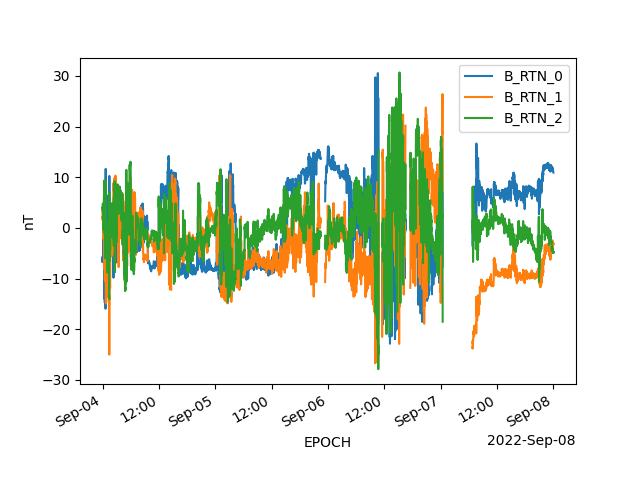

In [55]:
fig = plt.figure()
solo_mag.plot(columns=["B_RTN_0", "B_RTN_1", "B_RTN_2"])

In [56]:
res_solo_swa = Fido.search(a.Time(tstart_insitu, tend_insitu), 
                           a.cdaweb.Dataset.solo_l2_swa_pas_grnd_mom)
f_soloswa = Fido.fetch(res_solo_swa, path="./")
solo_swa_pas = sunpy.timeseries.TimeSeries(f_soloswa, concatenate=True)

Files Downloaded:   0%|          | 0/4 [00:00<?, ?file/s]

In [57]:
solo_swa_pas.columns

['Half_interval',
 'Info',
 'N',
 'P_RTN_0',
 'P_RTN_1',
 'P_RTN_2',
 'P_RTN_3',
 'P_RTN_4',
 'P_RTN_5',
 'P_SRF_0',
 'P_SRF_1',
 'P_SRF_2',
 'P_SRF_3',
 'P_SRF_4',
 'P_SRF_5',
 'SCET',
 'T',
 'TxTyTz_RTN_0',
 'TxTyTz_RTN_1',
 'TxTyTz_RTN_2',
 'TxTyTz_SRF_0',
 'TxTyTz_SRF_1',
 'TxTyTz_SRF_2',
 'V_RTN_0',
 'V_RTN_1',
 'V_RTN_2',
 'V_SOLO_RTN_0',
 'V_SOLO_RTN_1',
 'V_SOLO_RTN_2',
 'V_SRF_0',
 'V_SRF_1',
 'V_SRF_2',
 'quality_factor',
 'total_count',
 'unrecovered_count']

<Axes: xlabel='Epoch', ylabel='1 / cm3'>

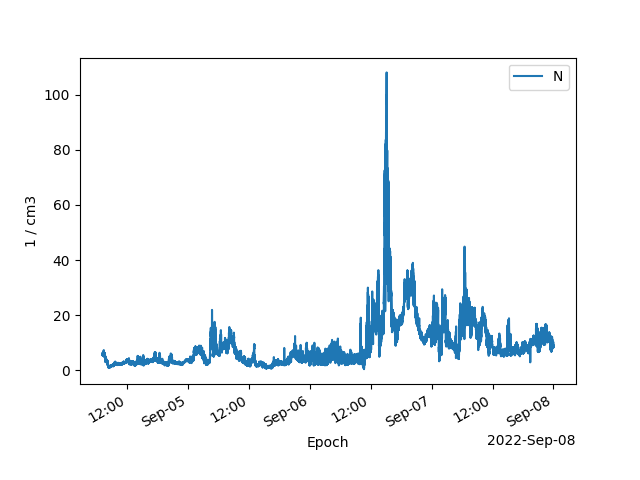

In [58]:
fig = plt.figure()
solo_swa_pas.plot(columns=["N"])

<Axes: xlabel='Epoch', ylabel='eV'>

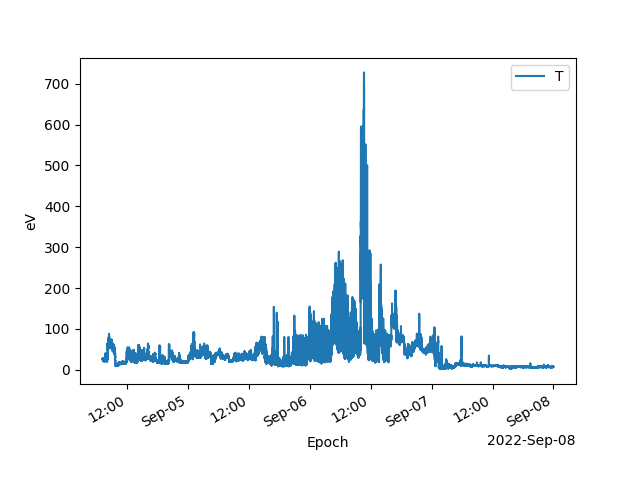

In [59]:
fig = plt.figure()
solo_swa_pas.plot(columns=["T"])

## Lets also look for some PSP FIELDS/MAG data

In [60]:

result_psp_mag = Fido.search(a.Time(tstart_insitu, tend_insitu), 
                     a.cdaweb.Dataset.psp_fld_l2_mag_rtn_1min)
f_mag_psp = Fido.fetch(result_psp_mag, path="./")

psp_mag = sunpy.timeseries.TimeSeries(f_mag_psp, concatenate=True)

Files Downloaded:   0%|          | 0/4 [00:00<?, ?file/s]

In [61]:
clean_psp = psp_mag._data[psp_mag._data["psp_fld_l2_quality_flags"].isnull()]
psp_event = sunpy.timeseries.TimeSeries(clean_psp, psp_mag.meta, psp_mag.units)

<Axes: ylabel='nT'>

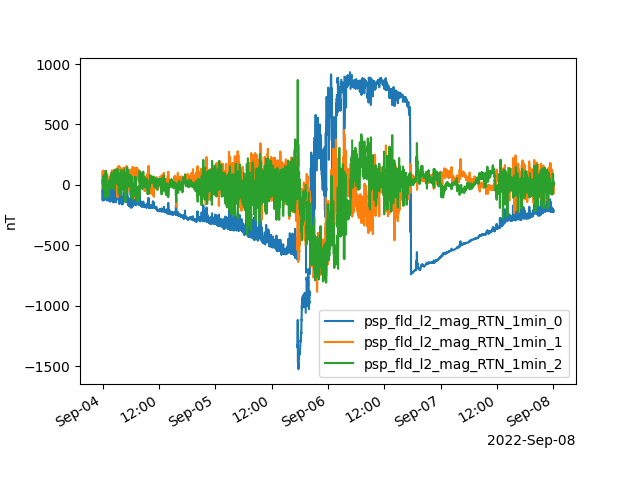

In [62]:
fig = plt.figure()
psp_event.plot(columns=['psp_fld_l2_mag_RTN_1min_0', 
                        'psp_fld_l2_mag_RTN_1min_1',
                        'psp_fld_l2_mag_RTN_1min_2'])

# Lets plot all of these together

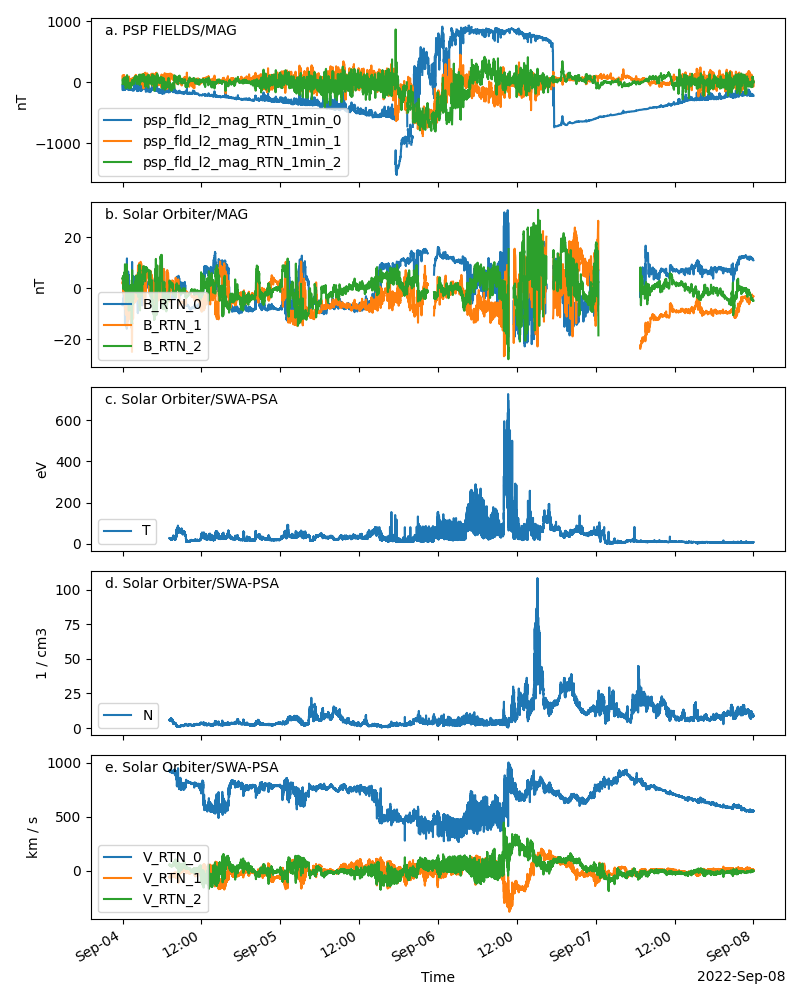

In [63]:
fig, ax = plt.subplots(5, figsize=(8, 10), sharex=True)

psp_event.plot(columns=['psp_fld_l2_mag_RTN_1min_0', 
                        'psp_fld_l2_mag_RTN_1min_1',
                        'psp_fld_l2_mag_RTN_1min_2'], 
              axes=ax[0])
solo_mag.plot(columns=['B_RTN_0', 'B_RTN_1', 'B_RTN_2'], axes=ax[1])
solo_swa_pas.plot(columns=['T'], axes=ax[2])
solo_swa_pas.plot(columns=['N'], axes=ax[3])
solo_swa_pas.plot(columns=['V_RTN_0', 'V_RTN_1', 'V_RTN_2'], axes=ax[4])
ax[4].set_xlabel("Time")

for aa in ax:
    aa.legend(loc="lower left")
    # aa.axvline(flare_time.datetime, color='r')

ax[0].text(0.02, 0.90, "a. PSP FIELDS/MAG", transform=ax[0].transAxes)
ax[1].text(0.02, 0.90, "b. Solar Orbiter/MAG", transform=ax[1].transAxes)
ax[2].text(0.02, 0.90, "c. Solar Orbiter/SWA-PSA", transform=ax[2].transAxes)
ax[3].text(0.02, 0.90, "d. Solar Orbiter/SWA-PSA", transform=ax[3].transAxes)
ax[4].text(0.02, 0.90, "e. Solar Orbiter/SWA-PSA", transform=ax[4].transAxes)

plt.tight_layout()


## Lets look at WISPR data for this event!

In [64]:
res_wispr = Fido.search(a.Time(tstart, tend), 
                  a.Instrument("WISPR"))

In [66]:
inds = []
for i in range(len(res_wispr[0]["fileid"])):
    if "L3" in res_wispr[0]["fileid"][i]:
        inds.append(i)
resp_wispr_l3 = res_wispr[0][inds]

In [67]:
Fido.fetch(resp_wispr_l3, path="./{instrument}/{file}")

Files Downloaded:   0%|          | 0/116 [00:00<?, ?file/s]

['WISPR/psp_l3_wispr_20220905t143016_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t143508_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t144516_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t145008_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t150016_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t150508_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t151516_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t152008_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t153016_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t153508_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t154516_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t155008_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t160016_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t160508_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t161516_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t162008_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t163016_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t163508_v1_2222.fits', 'WISPR/psp_l3_wispr_20220905t164516_v1_1211.fits', 'WISPR/psp_l3_wispr_20220905t1

In [68]:
wispr_outer_maps = sunpy.map.Map("./WISPR/*_2222.fits")
wispr_inner_maps = sunpy.map.Map("./WISPR/*_1211.fits")

In [69]:
wispr_norm = ImageNormalize(stretch=PowerStretch(1/2.2))

In [70]:
vmax_inner = 1.545e-11
vmax_outer = .5e-11

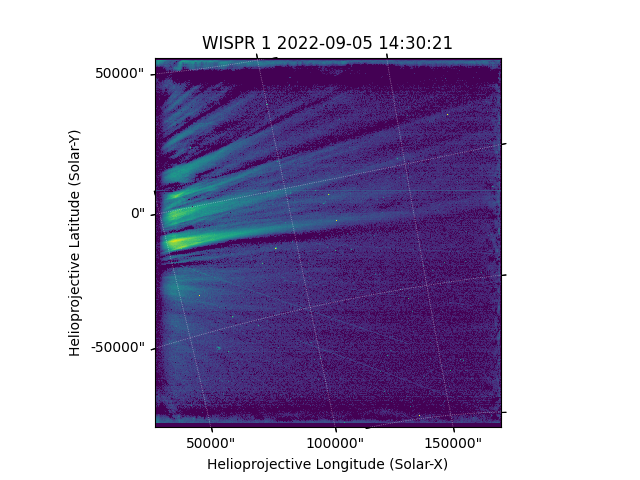

In [71]:
fig = plt.figure()
wispr_inner_maps[0].plot(vmin=0, vmax=0.5e-11, norm=wispr_norm, cmap="viridis")


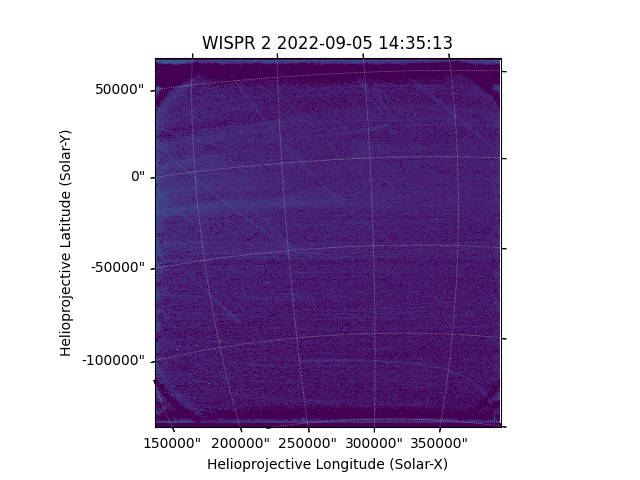

In [72]:
fig = plt.figure()
wispr_outer_maps[0].plot(vmin=0, vmax=0.5e-11, norm=wispr_norm, cmap="viridis")

In [73]:
def combine_wispr_maps(inner_map, outer_map):
    ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                         frame=frames.Helioprojective(observer=inner_map.observer_coordinate, obstime=inner_map.date))
    
    
    outshape = (360*2, int(360*3.5))
    new_header = sunpy.map.make_fitswcs_header(outshape, 
                                  ref_coord,
                                  reference_pixel=u.Quantity([40*u.pixel, 500*u.pixel]), 
                                  scale=u.Quantity([0.1*u.deg/u.pixel, 0.1*u.deg/u.pixel]), 
                                  projection_code="CAR"
                                 )
    
    out_wcs = WCS(new_header)
    with frames.Helioprojective.assume_spherical_screen(inner_map.observer_coordinate):
        array, footprint = reproject_and_coadd((inner_map, outer_map), out_wcs, outshape,
                                               reproject_function=reproject_interp)
    return sunpy.map.Map((array, new_header))

In [74]:
combined_wispr = combine_wispr_maps(wispr_inner_maps[0], wispr_outer_maps[0])

<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit    wrap   format_unit visible
  ----- ------- --------- ---- --------- ----------- -------
      0     lon longitude  deg 180.0 deg         deg     yes
      1     lat  latitude  deg      None         deg     yes

>

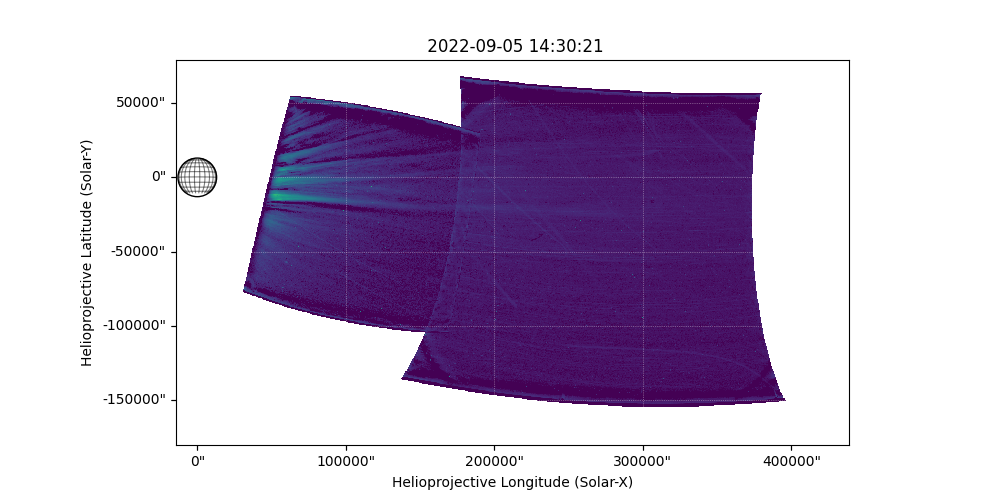

In [75]:
fig = plt.figure(figsize=(10, 5))
combined_wispr.plot(vmin=0,vmax=1e-11, norm=wispr_norm, cmap="viridis")
combined_wispr.draw_limb(color='k')
combined_wispr.draw_grid(color='k')

In [76]:
combined_wispr_maps = sunpy.map.Map([combine_wispr_maps(wispr_inner_maps[i], wispr_outer_maps[i]) for i in range(len(wispr_inner_maps))], sequence=True)

In [77]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=combined_wispr_maps[0])
ani = combined_wispr_maps.plot(norm=ImageNormalize(stretch=PowerStretch(1./2.2), vmin=0, vmax=1e-11), cmap="viridis", axes=ax)
combined_wispr_maps[0].draw_limb(color='k')
ani.save("wispr_movie.mp4")
plt.close()

In [78]:
from astropy.time import Time

In [79]:
wispr_map_times = Time([m.date for m in combined_wispr_maps])
eui_map_times = Time([m.date for m in eui_subs_304])

# Calculate light travel time between wispr maps and eui map times

In [80]:
solo_coords_at_psp_times = get_horizons_coord("solo", wispr_map_times)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


In [81]:
psp_times_at_solo = [((solo_coords_at_psp_times[i].radius - combined_wispr_maps[i].observer_coordinate.radius)/const.c).to(u.s) for i in range(len(combined_wispr_maps))]

In [82]:
wispr_map_times[11]+psp_times_at_solo[11]

<Time object: scale='utc' format='isot' value=2022-09-05T17:20:37.218>

In [83]:
np.argmin(np.abs(eui_map_times - (wispr_map_times[10]+psp_times_at_solo[10])))

10

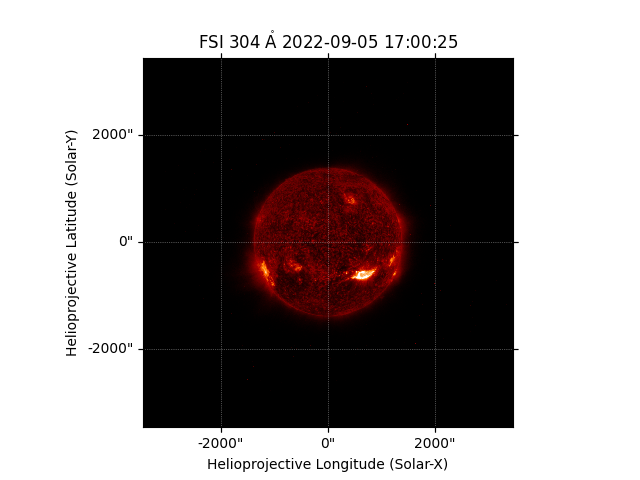

In [84]:
fig = plt.figure()
eui_subs_304[10].plot()

In [85]:
reprojected_eui =eui_subs_304[10].reproject_to(combined_wispr_maps[11].wcs)

/var/folders/wm/gysdzbp10qv1kcm4zxb5q95xkjzv5q/T/ipykernel_35665/666488588.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 5))


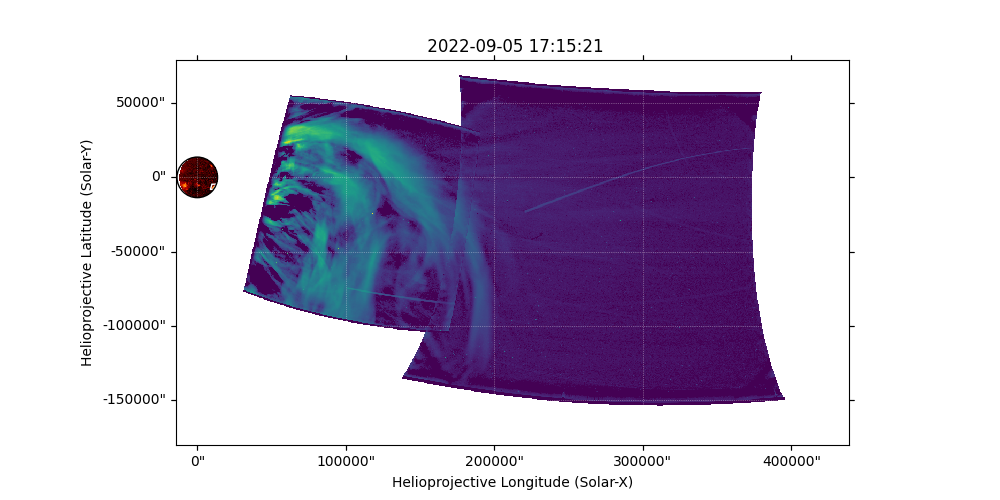

In [86]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=combined_wispr_maps[11])
combined_wispr_maps[11].plot(norm=ImageNormalize(stretch=PowerStretch(1./2.2), vmin=0, vmax=1e-11), cmap="viridis")
reprojected_eui.plot()
reprojected_eui.draw_limb(color='k')
eui_subs_304[10].draw_quadrangle(SkyCoord(400*u.arcsec, -750*u.arcsec, frame=eui_subs_304[10].coordinate_frame),
                                 top_right=SkyCoord(900*u.arcsec, -400*u.arcsec, frame=eui_subs_304[10].coordinate_frame))

In [1]:
shape_out = (720, 1440)
frame_out = SkyCoord(0, 0, unit=u.deg,
                     frame="heliographic_stonyhurst",
                     obstime=eui_subs_304[0].date,
                     rsun=eui_subs_304[0].coordinate_frame.rsun)
header = sunpy.map.make_fitswcs_header(shape_out,
                                       frame_out,
                                       scale=(360 / shape_out[1],
                                              180 / shape_out[0]) * u.deg / u.pix,
                                       projection_code="CAR")
out_wcs = WCS(header)

NameError: name 'SkyCoord' is not defined